# **Reproducing the results in the paper "Deep learning with multimodal representation for pancancer prognosis predictions"**
The goal of this notebook is to present our attemps on reproducing the paper "Deep learning with multimodal representation for pancancer prognosis predictions". Throughout the notebook, we try to replicate the main tables and figures, reporting the process and whether we succeed at it or not.




# **INDEX**

1.   Introduction
>*   Approach
2.   The data
3.   Reproducing Table 1
4.   Reproducing Figure 1
5.   Getting the code up and running
>*   Fetching the data
6.  Understanding the Network
>*  Inputs
>* Combining the feature vectors
>* Outputs
7.  Loss functions
8.  Results of the experiments



# **Introduction**
This paper tries to develop a tool of multimodal estimation of the evolution of patients with cancer. A neural network is built to predict the survival of patients with 20 different types of cancer using data from:
mRNA expression data, microRNA expression data and histopathology whole slide images (WSIs).

The authors claim that the multimodality of the data makes it difficult for physicians to find patterns. The presence of information from many patients and many different types of cancer can be of advantage for machine learning to exploit similarities. Nevertheless, it is still a challenging task due to the heterogeneity and high dimensional nature of the available data.

# ***Approach***

The difficulty of this paper lays on the data. Reproduction requires downloading Terabytes of information in many different formats from databases that are updated regularly. Just getting around downloading, understanding and opening the data took the first 2 to 3 weeks of work. To not delay ourselves more learning how to manage all of it, we decided to start from the code provided by the authors as a base. Nevertheless, we found two big problems with it. Firstly, the code contains deprecated functions, calls for files of unknown origin, etc. Secondly, it carries out, in many cases, processes that don't relate to what the paper describes.

As a result, with the limited amount of time and resources of this Reproducibility Project, we decided the following approach. We first fixed the code with slight modifications that helped us run it in the end. We then made efforts to understand the code as it was written, which turned out to be a difficut task. Then, we reported every process that is inconsistent with the description of the paper and suggest how it should be fixed. With this we hope to help the reader understand the process that the paper describes in a practical environment, since we found it very hard to follow from the paper. In the cases in which the paper provides insuficient information to write a proper code, we have reported it too.

#**The data**

The paper claims to retrieve most of its data from "PanCanAtlas TCGA project" which containts information on 11160 patients. This includes microRNAs, gene expression, clinical data and WSIs among other things. Not all data is available for all patients so networks have to be able to deal with missing data. 


Retrieving the data to perform the experiment was simple for the majority of the cases. A code by Soufiane Mourragi was used for such purpose (link to code?¿). The code downloads the data directly from the source which could have been updated since the paper was written.


Nevertheless, it is important to note the special case of the WSIs. Each type of cancer contains Terabytes of information in the form of this high quality histological images. To reduce the computational cost for the network, the paper describes a process in which some randomly selected ROIs are taken to represent approximately 15% of the information in the WSI. 
By our limited resources, we only downloaded the WSI data for Pancreas cancer as it was the smallest dataset available (700Gb). Download was made in batches of 15-20 files (.svs) at a time. Then, compression was applied to them to reduce the storage burden. This whole process took a full week.

The compression code provided by the authors did not work straight away. We will next describe the modifications needed to attain the desired result.




Initially, they import all the necessary packages. We noticed scipy.mist was deprecated so we used PIL instead

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os, sys, random, yaml, shutil, time, glob
import IPython

import openslide
#OLD
#from scipy.misc import imresize

#NEW
from PIL import Image
#import pickle
#END NEW

Then a function is defined to open the .svs files which contain the histological slides.

In [0]:
def open_slide(slide_image_path):
	return openslide.open_slide(slide_image_path)


Next, the function that selects random ROIs of each slide is defined. The paper claims the process is to select 200 ROIs of 224x224 pixels. The code, on the other hand, takes window sizes of 400 and then resizes to 100. 
Then, some averages are computed, we think, to discard regions with non representative information. 
In the paper, the process they claim to follow is different. It consists on computing the average RGB colors of the WSI and then compute the mean square distance with those of the ROI, giving an approximation of the meaningfullness of the region.


In [0]:
def sample_from_slides(slides, window_size=400, view_size=100, num=10):
	
	samples = []
	while len(samples) < num:
		slide = random.choice(slides)
		XMAX, YMAX = slide.dimensions[0], slide.dimensions[1]

		xv, yv = random.randint(0, XMAX - window_size), random.randint(0, YMAX - window_size)
		window = np.array(slide.read_region((xv, yv), 0, (window_size, window_size)))
		#plt.imshow(window); plt.show()
		
		if np.array(window).mean() > 200:
			continue

		if np.array(window[:, :, 0]).mean() < 50:
			continue

		if np.array(window[:, :, 2]).mean() > 160:
			continue
		#OLD
		#window = imresize(window, (view_size, view_size, 4))
                #window= np.array(Image.fromarray(window).resize(view_size, view_size, 4))

		#NEW
		img = Image.fromarray(window)
		window = img.resize(size = (view_size, view_size))
		window = np.array(window)
		#END NEW
		
                #window.resize((view_size, view_size, 4))
		#plt.imshow(window); plt.show()
		samples.append(window)
		

	return np.array(samples)

Then, another function is defined to read every downloaded file and run the previously defined function to obtain the ROIs. Since we downloaded data differently, we addapted the fetching lines to fit our own situation and computer paths.

In [0]:
def sample_from_patient(case, window_size=400, view_size=100, num=10):
        #OLD
        #slide_files = glob.glob(f"/Volumes/Seagate Backup Plus Drive/tissue-slides/{case}*.svs")

        #NEW
        path="/Users/arturo/Downloads/GDC_download-master/tmp/Pancreas_PAAD_slide/raw" #specific for each computer
        slide_files = [os.path.join(path,case)]
        #slide_files = os.path.join(path,case)
        #print(slide_files)
        #for file in slide_files:
        #        print(file)
        #END NEW
        
        slides = [open_slide(file) for file in slide_files]
        if len(slides) == 0: return None
        return sample_from_slides(slides, window_size=window_size, view_size=view_size, num=num)


Lastly, the main body of the code can be seen. The main problem found in this part was that they were calling a non existent .yaml file. Many people asked for it in the github discussion section with no reply. 

We developed a code that would read all the folders that the downloading code created previously.

In [0]:
if __name__ == "__main__":

        #OLD
        #data = yaml.load(open(f"data/processed/case_files_locs.yaml"))
	      #cases = data.keys()

        #NEW
        cases =[]
        path="/Users/arturo/Downloads/GDC_download-master/tmp/Pancreas_PAAD_slide/raw"

        data=os.listdir(path)  #This contains all the names of the folders within raw
        #print(data)
        data.remove("metadata_Pancreas_slide")
        data.remove("query_results_Pancreas_slide")
        data.remove(".DS_Store")
        for i in data:
                a=os.path.join(path,i)
                #print(a)
                file=os.listdir(a)
                #print(file)
                #file.remove(".DS_Store")
                #print(file)

                # the following code aims to find the .svs file within a folder 
                #which can either have 1 or 2 other files depending on its download. 
                #They are unordered and so we take all options into account
                
                if file[0].endswith(".svs"):
                        cases.append(os.path.join(a,file[0]))
                if file[1].endswith(".svs"):
                        cases.append(os.path.join(a,file[1]))
                if file[2].endswith(".svs"):
                        cases.append(os.path.join(a,file[2]))
        #print (cases)
        #END NEW

Then we adapted the code to order the rois and save them one after the other in a convenient way to open them from Google Collab instead of one of our private computers.

Another important thing to mention is that this code takes 10 random patients to obtain the 40 images from. We adapted the code for it to read every patient and take 40 ROIs from each as we interpreted the paper describes.

In [0]:
        #OLD
        #rois = [sample_from_patient(case, num=4) for case in random.sample(cases, 10)]
        #print(len(rois))
        #rois=[roi_set for roi_set in rois if roi_set is not None]
        #rois= np.array([roi for roi_set in rois for roi in roi_set])
        #print(rois)

        #NEW
        for j in cases:
                rois=[sample_from_patient(j, num=40)]
                print(len(rois))
                rois=[roi_set for roi_set in rois if roi_set is not None]
                rois= np.array([roi for roi_set in rois for roi in roi_set])
                print(rois)
                np.save(j, rois)
                print(j)
        #END NEW
        

A resizing to 64x64 is done even though the paper claims to look for images of 224x224. Then they are save them in .png files. 

In [0]:

        #OLD
	      #print (rois.shape)
	      #rois = torch.tensor(rois).permute((0, 3, 1, 2))[:, 0:3]
	      #print (rois.shape)
	      #transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize(64),transforms.ToTensor()])
      	#rois = torch.stack([transform(x) for x in rois.cpu()])
      	#print (rois.shape)	
      	#image = make_grid(rois, nrow=4)
      	#print (image.shape)
      	#plt.imsave("results/rois.png", image.permute((1, 2, 0)).data.cpu().numpy())
	
  
        #NEW    
        #print(rois.shape)
        #np.save('rois', rois)
        #rois = torch.tensor(rois).permute((0, 3, 1, 2))[:, 0:3]
        #transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(64), transforms.ToTensor()])
        #rois = torch.stack([transform(x) for x in rois.cpu()])
        #print (rois.shape)

        #image = make_grid(rois, nrow=40)
        #print (image.shape)
        #plt.imsave("/Users/arturo/Downloads/GDC_download-master/tmp/results/rois.png", image.permute((1, 2, 0)).data.cpu().numpy())
        #np.save('rois', rois)
        #END NEW


Summarizing the difficulties found were the following: It took a week to download all the WSI data for just one cancer type. The code was modified to work as it was but it does not do as the paper describes and it is still specific for the personal computer of one of the reproducers. 


Due to the limited time and resources of this project, we decided to drop the use of slides to reproduce the paper.


# **Reproducing Table 1**
As mentioned above, the authors of the paper use as source data the one from the [PanCanAtlas TCGA project](https://gdc.cancer.gov/about-data/publications/pancanatlas). This project contains microRNAs, gene expression, clinical data and WSIs information, among others, of over 11000 patients. However, not all data types are available for all patients. As stated in the paper, one of its goals is to ensure their work is robust to missing data.

Table 1 in the paper contains the data distribution of the TCGA data, at the time it was retrieved for use in their results. However, as the TCGA project is an "alive" project which encourages new submissions, we believe it is necessary to evaluate how large the source data modification is.

![alt text](https://drive.google.com/uc?id=1FO1mdHRJzEgNkKVxNF57EaRhs-zrkeVv)
<img src="figure1 (2).png">
Once the data was obtained following the procedure stated above, we reproduced Table 1 as shown below.

>Data Type | Number of cases | Number of missing cases | Percentage missing (%)
>--- | --- | --- | ---
>Gene expression data | 9363 | 1950 | 20.82
>MicroRNA expression data | 9258 | 2055 | 22.19
>Clinical data | 10168 | 1145 | 11.26
>Survival target data (time of death) | 11094 | 73 | 0.65

As expected, a quick glance allows to see how the values are not exactly the same, although they are quite similar. The following points are worth remarking:

*  We were not able to obtain the information about the distribution of TCGA data in the case of WSI slide data, and therefore the number of patients with complete data. The reason is related to the troubles for downloading the slides due to its large size. 
* The total number of cases has increased slightly from when the authors downloaded their data, going from 11160 to 11313.
* The number of missing cases we obtain is way smaller than the one in the paper. The reason why is that it is not clear when the authors consider a case has the complete clinical data. The papers mentions that the dataset contains "a wide range of clinical data, from which we used the race, age, gender and histological grade variables"; nevertheless, the clinical files do not have any variable with the name “histological” or similar.
* The paper specified that the dataset they work with contains gene expression data for 60383 genes; however, when inspecting the data we found that number to be 60483.



# **Reproducing Figure 1**
The authors of the paper created Kaplan-Meier survival curves for the 32 cancer sites in the dataset. These curves present the survival probability at each time step for each cancer site, based on the days to death of each patient in the dataset, since the cancer was diagnosed.

![alt text](https://drive.google.com/uc?id=1TP8mdg40HrJgwZ2dRfmOtsTtNo4tnqfR)

The code for reproducing these curves is not provided. We thoroughly tried to recreate these curves; however, the paper does not specify in any way the procedure followed for computing the survival probability for each cancer site. As we are not Statistics experts, we searched online and implemented the Kaplan-Meier estimation formula from a [blog](https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e) that made the most sense:

>$\hat{S}(t) = \prod_{i:t_i\leq t} \frac{n_i - d_i}{n_i} $

Where $n_i$ is the dead events at each time step and $d_i$ is the population at risk at the timestep just before $t_i$.

Furthermore, the paper does not specify whether they followed some exclusion criteria for the TCGA dataset to perform this analysis. For instance, they do not specify whether they excluded data from patients who did not have the clinical data available. Given this, we chose to consider all patients included in the clinical dataset, even if some variables were missing.


**Implementation of the Kaplan-Meier survival curves**
The implementation of the Kaplan-Meier survival curves is done using Python following four mains steps: 

1.   Retrieving the clinical data and relating each patient case to its corresponding cancer site, which is done using the Biospecimen data provided by the TCGA dataset
2.   Extracting meaningful information from the clinical data and creating a dataframe containing it: for each patient, primary diagnosis, vital status, days to death
3. Extracting the survival probability using the formula stated above, based on the number of alive and dead patients at each time step
4. Plotting the survival curves

A link to the code used to compute these curves is provided HERE *(right now is at the end of the document but it will be moved somewhere else)*.


**Evaluating the success of the reproduction**

The survival curves produced in our attempt to reproduce the original ones follow a similar trend to those in the paper. However, by focusing on each of the individual cancer sites and comparing, we see there are noticeable differences.

![fig1(left)](https://drive.google.com/uc?id=121q6fWRIMycXb4DLVxcJeflMKnfT3wrC)

![fig2(right)](https://drive.google.com/uc?id=1nE9pNu0X0mWYe7_XMYucCcuRozVuNpd-)

As stated above, we believe the lack of explanation on the procedure followed to create the figures and on which clinical data is excluded or taken into account has a large impact on these results. Furthermore, the TCGA dataset is constantly being updated, which might as well influence the difference in results.

In [1]:
# IMPLEMENTATION: PART I

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from google.colab import drive
drive.mount('/content/drive')

# ========= Define and Open Clinical Data Paths ======================
clinical_data_path = '/content/drive/My Drive/DL Reproducibility Project/tmp/original_clinical_dataset.json'

with open(clinical_data_path) as f:
  clinical_data = json.load(f)

cases = []

# Get case id for each patient from submitter_id (12 char)
for i in range(len(clinical_data)):
  id = clinical_data[i]['demographic']['submitter_id'][0:12]
  cases.append(id)
print(cases[0:5])

# ========= Load Biospecimen data ===================
# used to find the connection between barcode-ids 'TCGA-60-2708'
# with the project names: 'PAAD', 'LUSC' etc

# Get project name from case/barcode (12 char)
biospec_path = '/content/drive/My Drive/DL Reproducibility Project/MultimodalPrognosis/data/processed/pancancer_biospecimen.csv'
csv_file = pd.read_csv(biospec_path)
csv_file['barcode2'] = csv_file['barcode'].str.slice(0, 12, 1) 

project = []

#find the connection between barcode-ids 'TCGA-60-2708'
# with the project names: 'PAAD', 'LUSC' etc
for case in cases:
  
  a = csv_file[csv_file['barcode2'] == str(case)]['project']
  if len(a) > 0:
    a = a.iloc[0]
    a = a[5:]
    project.append(a)
  else:
    project.append(None)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
['TCGA-CJ-4885', 'TCGA-AK-3444', 'TCGA-A3-3319', 'TCGA-J9-A8CM', 'TCGA-HC-7075']


In [0]:
# IMPLEMENTATION: PART II

range_clinical_cases = np.arange(1, (len(clinical_data))) #starts at 1 because clinical_data[0] should be ignored

#Extracting meaningful clinical info into different dataframes that will be later concantenated
# First, primary diagnosis
primary_diagnosis = {'primary_diagnosis': [clinical_data[i]["diagnoses"][0]['primary_diagnosis'] for i in range_clinical_cases]}
df_primary = pd.DataFrame(primary_diagnosis, columns=['primary_diagnosis'])
# Second, vital status
vital_status = {'vital_status': [clinical_data[i]["demographic"]['vital_status'] for i in range_clinical_cases]}
df_vital = pd.DataFrame(vital_status, columns=['vital_status'])

# Third, days to death
days_to_death = {'days_to_death': [0 for i in range_clinical_cases]}
df_days = pd.DataFrame(days_to_death, columns=['days_to_death'])
for i in range_clinical_cases:
  if "days_to_death" in clinical_data[i-1]["demographic"]:
    x = [clinical_data[i-1]["demographic"]["days_to_death"]]
    df_days.iloc[i-2, df_days.columns.get_loc('days_to_death')] = x[0]

#Concatenating all dataframes into a single one containing, for each patient, primary diagnosis, vital status, days to death
result = pd.concat([df_primary, df_vital, df_days], axis=1, sort=False)

In [0]:
# IMPLEMENTATION: PART III

cancer_sites = ['ACC', 'BRCA', 'CESC', 'DLBC', 'KICH', 'KIRC', 'KIRP', 'OV', 'PCPG', 'PRAD', 'SARC', 'SKCM', 'TGCT', 'THCA', 'THYM', 'UCEC', 'BLCA', 'CHOL', 'COAD', 'ESCA', 'GBM', 'HNSC', 'LGG', 'LIHC','LUAD', 'LUSC', 'MESO', 'PAAD', 'READ', 'STAD', 'UCS', 'UVM']
day_range = np.arange(1,11000) # From day 1 to day 11000, starting at day 1 because at day at time 0 all patients are assumed to be alive
rango = np.arange(0, (len(project)-1)) # From patient 0 to patient 11166
prob_all_stacked = np.arange(1,11000) # It will store the survival probability at each time step, from 1 to 11
for x in cancer_sites:
  days_to_death_array = np.array([]) # It will store the days to death, for each patient case in each cancer site
  for i in rango:
    if (project[i] == x): # If the patient case corresponds to the x cancer site
      days_to_death = result.iloc[i, result.columns.get_loc('days_to_death')]
      days_to_death_array = np.append(days_to_death_array, days_to_death)
      number_patients = len(days_to_death_array) # The number of patient cases for this cancer site, in total
      probability = np.array([]) # It will contain the survival probabilities for this cancer site
  alive = number_patients; # Initial number of patients, which are alive at t = 0
  alive_array = np.zeros(11000) # Array containing the number of alive patients at each time step
  alive_array[0] = number_patients
  for r in day_range: # Loop going from day 1 to day 11000
    dead = 0 # This variable will store the number of dead patients at this timestep (r)
    for j in range(number_patients): 
      if days_to_death_array[int(j)] == r: # It goes through the array containing the days to death of each patient with this cancer site and checks whether they died at timestep r
        dead = dead +1 # If it died at r, it scores
        alive = alive - 1
    alive_array[r] = alive # It updates the number of alive patients at timestep r
    # Computing the survival probability at each time step, using the number of dead at this time step, and the number of alive patients up until this timestep
    if r == 1:
      probability = np.append(probability,(alive_array[0] - dead)/alive_array[0])
    else:
      p2 = (alive_array[r-1] - dead)/alive_array[r-1]
      probability = np.append(probability, probability[r-2]*p2)
  prob_all_stacked = np.vstack([prob_all_stacked, probability]) # Stacking in a matrix all cancer sites for storing purposes

[(0.0, 1.0), (0.0, 11000.0)]

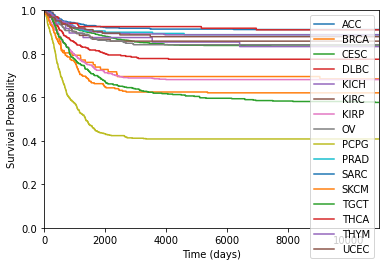

In [6]:
# IMPLEMENTATION: PART IV (FIGURE 1, LEFT)
ax = plt.gca()
labels1 = ['ACC', 'BRCA', 'CESC', 'DLBC', 'KICH', 'KIRC', 'KIRP', 'OV', 'PCPG', 'PRAD', 'SARC', 'SKCM', 'TGCT', 'THCA', 'THYM', 'UCEC']
[ACC, BRCA, CESC, DLBC, KICH, KIRC, KIRP, OV, PCPG, PRAD, SARC, SKCM, TGCT, THCA, THYM, UCEC] = plt.plot(day_range, np.transpose(prob_all_stacked[0:16, :]),label = labels1)
plt.legend([ACC, BRCA, CESC, DLBC, KICH, KIRC, KIRP, OV, PCPG, PRAD, SARC, SKCM, TGCT, THCA, THYM, UCEC], labels1, loc=1)
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
ax.set(xlim=(0, 11000), ylim=(0, 1))

[(0.0, 1.0), (0.0, 11000.0)]

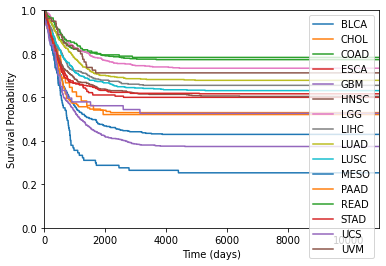

In [7]:
# IMPLEMENTATION: PART IV (FIGURE 1, RIGHT)

ax = plt.gca()
labels2 =  ['BLCA', 'CHOL', 'COAD', 'ESCA', 'GBM', 'HNSC', 'LGG', 'LIHC','LUAD', 'LUSC', 'MESO', 'PAAD', 'READ', 'STAD', 'UCS', 'UVM']
[blca, chol, coad, esca, gbm, hnsc, lgg, lihc, luad, lusc, meso, paad, read, stad, ucs, uvm] = plt.plot(day_range, np.transpose(prob_all_stacked[17:33, :]),label = labels2)
plt.legend([blca, chol, coad, esca, gbm, hnsc, lgg, lihc, luad, lusc, meso, paad, read, stad, ucs, uvm], labels2, loc=1)
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
ax.set(xlim=(0, 11000), ylim=(0, 1))

# **Getting the code up and running**

## **Fetching the data**

### Intro

Conveniently, the paper provides a link to the [code](https://github.com/gevaertlab/MultimodalPrognosis) used to achieve the presented results. According to the [README](https://github.com/gevaertlab/MultimodalPrognosis/blob/master/README.md), running the code should be an easy task. However, as soon as we attempt to run the experiments, we start encountering numerous **errors and problems**. In this section we describe these problems, and the changes we had to make before the code was up and running.

### Fetching the data
The network is trained using batched data provided by a `DataGenerator`, inheriting from the `AbstractPatientGenerator` defined in `generators.py` 

```
class AbstractPatientGenerator(object):

	def __init__(self, cases=fetch.cases, samples=500, val_samples=100, verbose=False):
		super(AbstractPatientGenerator, self).__init__()
		self.train_cases, self.val_cases = train_test_split(list(cases), test_size=0.15)
		self.samples, self.val_samples = samples, val_samples
		self.verbose = verbose

(...)
```

When a `DataGenerator` is instantiated, a list of "cases" is fetched from [`fetch.py`](https://github.com/gevaertlab/MultimodalPrognosis/blob/master/data/fetch.py), which has to be imported (which initially did not work due to the folder structure). `fetch.py` tries to load data from a cache file `fetch_datacache.npz`. However this datafile is **not provided**, as already noted by many others: It has been marked as an [issue](https://github.com/gevaertlab/MultimodalPrognosis/issues/1) on GitHub since 15 September 2019. 

The list of cases comes from a YAML file:

```
data = yaml.load(open(f"{DATA_DIR}/processed/case_files_locs.yaml"))
cases = data.keys()
```

where the keys are the first 12 characters of [barcodes](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/). These strings, e.g. `'TCGA-29-1688'`, are used as identifiers for the cases. Corresponding to each identifyer, the YAML file contains a dictionary of file locations, such as:

```
{'clinical_data_file': 'files/45bfc548-c7d6-46e2-b649-e1b8fe32ede2/nationwidechildrens.org_clinical.TCGA-29-1688.xml',
 'gene_expression_file': 'files/7508650c-8a1f-40e1-ae61-b669ccabc83e/24b7176d-483b-416e-8ecd-d3beae934fc3.htseq.counts.gz',
 'isoform_expression_file': 'files/369ef139-b950-46c8-86e8-c58d55c99d4f/isoforms.quantification.txt',
 'mirna_expression_file': 'files/2fc6f7a9-1f19-40e1-b90b-5de690660132/mirnas.quantification.txt',
 'project': 'TCGA-OV'}
```

However, these file locations did not correspond to how our data was stored, possibly due to us following a different downloadning procedure. To solve this issue, we decided to rewrite fetch.py completely. In the process, we noted some interesting **discrepancies between the paper and the code**. In the following sections, these differences will be highlighted.





## **Understanding the network**

After finally solving the data related problems, we started digging into the definition of the network/s and the loss function/s. As it turns out, the published paper and code show some very large differences. Before we dig into the details, let's recap how the model is described in the paper:

>![Fig 2. Model overview](https://drive.google.com/uc?id=1x_J0epjyHHxD2Xx-x8M_MqCHCJ6Sui6R)

Unfortunately, [the code](https://github.com/gevaertlab/MultimodalPrognosis/blob/a14e0abfb8f5c758b0efc8c517e50939851d0503/experiments/chart5.py#L31), which is linked in the paper, tells another story. In the following sections we will highlight the differences that we have found.

### Inputs

The size of the input data from the different modalities seem correct in all cases except for the clinical data. In that case, the paper and code do not match. In the paper, four clinical variables are specified whereas the code uses seven. Wee see that the layer [`self.fcc = nn.Linear(7, 256)`](https://github.com/gevaertlab/MultimodalPrognosis/blob/a14e0abfb8f5c758b0efc8c517e50939851d0503/experiments/chart5.py#L55) takes a tensor of length 7 as input.

### Combining the feature vectors

Figure 2 from the **paper** suggests that data from different modalities are passed through different networks, each independently producing a 512-length feature vector. These vectors are then combined in some way which is **not clearly specified**.

The networks defined in the published **code** uses a significantly different approach. There, the data from each modality is first mapped to a 256-length vector via a fully connected layer (for gene expression, miRNA and clinical data) and via a SqueezeNet in the case of the Whole Slide Images. These four vectors are then combined into a new 256-length vector by taking the **element-wise mean** (compensating for missing modalities) of the four vectors. 

This single 256 vector, which thus is based on the data from all available modalities, are then fed into the Highway network. This should be compared to the paper, which states that only the Gene expression and miRNA data are fed through the Highway network.



### Outputs
The **paper** specifies:
> "*Thus, we add a final prediction layer that maps the 512 feature vector to a survival prediction.*"

where the survival prediction means survival time, or time to death. Again, going to the **code** we find something different. There, the output from the highway module (again a 256 feature vector), is mapped to two outputs: 

*   `score` : a softmaxed 2 vector. The values seems to be interpreted as probabilities in a 2 class classification, with the classes being to the two possible vital statuses of the patient: dead or alive.
*   `hazard` : a single number. The name suggests this should be interpreted as a hazard, which in survival analysis is the expected *rate of death* given survival up to a certain point. Such a hazard could be related to an expected survival time, the quantity mantioned in the paper. However, the connection is not obvious, and the disagreement between paper and code is curious.





## **Loss function**


During the forward pass, one more quantity is calculated:

* `ratio` : a single number. The interpretation of this number is definitely not easy. The code contains no comments with clues. The ratio is calculated based on some statistical properties of the four initial 256 feature vectors from the different modalities. This suggests some connection to what is describes as the *similarity loss* in the paper, intended to encourage the feature vectors from different patients and modalities to be related in a meaningful way, in the spirit of unsupervised representation learning. Despite serious effort to dissect the coad, the interpretation of `ratio` remains unclear to us.

For the curious, and to illustrate the difficulty of interpreting the uncommented code, we include a code snippet below. The example is from [chart2](https://github.com/gevaertlab/MultimodalPrognosis/blob/a14e0abfb8f5c758b0efc8c517e50939851d0503/experiments/chart2.py#L57), where only miRNA and clinical data is used. `x` and `y` are the two corresponding 256 feature vectors.


```
mean = masked_mean((x, y), (mask["mirna"], mask["clinical"]))

var = masked_variance((x, y), (mask["mirna"], mask["clinical"])).mean()
var2 = masked_mean (((x - mean.mean())**2, (y - mean.mean())**2), \
                            (mask["mirna"], mask["clinical"]))

ratios = var/var2.mean(dim=1)
ratio = ratios.clamp(min=0.02, max=1.0).mean()

```
where the masked mean and variance calculates the mean/variance across the modalities. The binary entries of the mask indicating which modalities to include in the calculations:
```
# Takes the masked mean of a tuple of data
def masked_mean(data, masks):
    num = sum((X*mask[:, None].float() for X, mask in zip(data, masks)))
    denom = sum((mask for mask in masks))[:, None].float()
    return num/denom

def masked_variance(data, masks):
    EX2 = masked_mean(data, masks)**2
    E2X = masked_mean((x**2 for x in data), masks)
    return E2X - EX2
```




Unfortunately the code defining the loss functions is **entirely uncommented**. To us, the relation between the loss function defined in the coda and the one described in the paper is vague at best. 

But in summary, the loss function defined in the code is a sum of three terms. See for example [`predict.py`](https://github.com/gevaertlab/MultimodalPrognosis/blob/a14e0abfb8f5c758b0efc8c517e50939851d0503/experiments/predict.py#L91)

```
def loss(self, pred, target):
  loss = F.nll_loss(pred["score"], vital_status)

  (... loss2 is defined here..)

  loss3 = pred["ratio"].mean()

  return loss + loss2 + loss3*0.3

```



*   `loss` is related to the classification of a patient being dead/alive. This loss is not mentioned in the paper.

*   `loss2` seems related to the Cox loss mentioned in the paper, as the calculations include sorting the patients by their predicted hazard, which in turn is related to sorting the patients by their expected time to death. How closely `loss2` corresponds to the Cox loss described in the paper is obscured by the highly unreadable and uncommented code.

*   `loss3` is related to some kind of similarity loss. Again, we fail to see the connection to the loss functions in the paper.


Unfortunately the code defining the loss functions is **entirely uncommented**. To us, the relation between the loss function defined in the coda and the one described in the paper is vague at best. 

But in summary, the loss function defined in the code is a sum of three terms. See for example [`predict.py`](https://github.com/gevaertlab/MultimodalPrognosis/blob/a14e0abfb8f5c758b0efc8c517e50939851d0503/experiments/predict.py#L91)

```
def loss(self, pred, target):
  loss = F.nll_loss(pred["score"], vital_status)

  (... loss2 is defined here..)

  loss3 = pred["ratio"].mean()

  return loss + loss2 + loss3*0.3

```



*   `loss` is related to the classification of a patient being dead/alive. This loss is not mentioned in the paper.

*   `loss2` seems related to the Cox loss mentioned in the paper, as the calculations include sorting the patients by their predicted hazard, which in turn is related to sorting the patients by their expected time to death. How closely `loss2` corresponds to the Cox loss described in the paper is obscured by the highly unreadable and uncommented code.

*   `loss3` is related to some kind of similarity loss. Again, we fail to see the connection to the loss functions in the paper.


## **Results of the experiments**

... I will add this tuesday /Johan